# Installation

conda create -n liana -y python=3.8 ipykernel # liana requires ipykernel

conda activate liana

-

conda install -c anaconda pytables

pip install torch

pip3 install torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

-

pip install decoupler cell2cell omnipath pyarrow liana

# Setup

In [ ]:
# Standard stuff
import scanpy as sc
import liana as li
from collections import defaultdict
import fast_matrix_market as fmm
import pandas as pd
import anndata as ad
import numpy as np
from statsmodels.stats.multitest import fdrcorrection

# Plotting
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt
import gseapy

# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# Ignore all FutureWarnings
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
dat = fmm.mmread("/work/msa/02_data/liana/all_cells.mtx")
cellIds = pd.read_csv("/work/msa/02_data/liana/all_cells.cells", header = None)
genes = pd.read_csv("/work/msa/02_data/liana/all_cells.genes", header = None)
anno = pd.read_csv("/work/msa/02_data/liana/all_cells.annotation", header = None)

sample = cellIds[0].str.split("!!").apply(lambda x: x[0])
condition = cellIds[0].str.split("!!").apply(lambda x: x[0]).str.split("_").apply(lambda x: x[0])

In [3]:
adata = ad.AnnData(X = dat.tocsr())
adata.obs_names = cellIds[0]
adata.var_names = genes[0]
adata.obs["anno"] = pd.Categorical(anno[1])
adata.obs["condition"] = pd.Categorical(condition)
adata.obs["sample"] = pd.Categorical(sample)
adata

AnnData object with n_obs × n_vars = 117281 × 25550
    obs: 'anno', 'condition', 'sample'

In [4]:
adata.obs

,anno,condition,sample
CTRL_037!!GCACATATCCTAGCCT-1,Neurons,CTRL,CTRL_037
CTRL_037!!GATAGCTCATGTTTGG-1,Neurons,CTRL,CTRL_037
CTRL_037!!GATAGAACATCCTATT-1,Neurons,CTRL,CTRL_037
CTRL_037!!GAGTGTTTCACCTTAT-1,Neurons,CTRL,CTRL_037
CTRL_037!!GGGTTTAAGTCCTACA-1,Neurons,CTRL,CTRL_037
...,...,...,...
PD_K1449!!TAGACTGTCGCCGAGT-1,Oligodendrocytes,PD,PD_K1449
PD_K1449!!AGGGTTTTCAGCATTG-1,Oligodendrocytes,PD,PD_K1449
PD_K1449!!GTAGCTATCCATATGG-1,Oligodendrocytes,PD,PD_K1449
PD_K1449!!TGGGAGACAGGTTCAT-1,Oligodendrocytes,PD,PD_K1449


In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## Run Liana

In [6]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby="anno",
    sample_key="sample", # sample key by which we which to loop
    use_raw=False,
    verbose=True, # use 'full' to show all verbose information
    n_perms=100, # reduce permutations for speed
    return_all_lrs=True, # return all LR values
    )

Now running: PD_K1449: 100%|██████████| 29/29 [11:47<00:00, 24.41s/it]


In [7]:
adata.uns["liana_res"].sort_values("magnitude_rank").head(10)

,sample,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
814335,CTRL_09148,Oligodendrocytes,Oligodendrocytes,IL1RAPL1,PTPRD,2.962296,0.0,8.486578,0.619537,1.823713,0.151969,0.972260,0.270358,0.0,0.000001,1.493559e-14
508160,CTRL_09055,Oligodendrocytes,Oligodendrocytes,IL1RAPL1,PTPRD,3.158201,0.0,9.722960,0.664447,2.481931,0.174373,0.972669,0.292412,0.0,0.000001,1.815376e-14
0,CTRL_037,Oligodendrocytes,Oligodendrocytes,IL1RAPL1,PTPRD,3.112508,0.0,9.469083,0.578140,2.807187,0.181624,0.970612,0.320442,0.0,0.000007,1.892919e-14
2522676,PD_7044,Oligodendrocytes,Oligodendrocytes,IL1RAPL1,PTPRD,3.089952,0.0,9.288337,0.972821,3.578449,0.204472,0.967172,0.281318,0.0,0.000003,1.924313e-14
2001204,MSA_1398,Oligodendrocytes,Oligodendrocytes,IL1RAPL1,PTPRD,3.248940,0.0,10.276344,0.620614,2.582659,0.194862,0.969217,0.305831,0.0,0.000008,2.299684e-14
2172661,MSA_1436,OPCs,OPCs,NRXN1,NLGN1,3.167408,0.0,10.030591,1.746693,2.046503,0.159092,0.970684,0.329382,0.0,0.000012,4.728285e-14
2172660,MSA_1436,OPCs,OPCs,NLGN1,NRXN1,3.167408,0.0,10.030591,1.746693,2.046503,0.159092,0.970684,0.329382,0.0,0.000012,4.728285e-14
183808,CTRL_039,OPCs,OPCs,NRXN1,NLGN1,3.393715,0.0,11.512754,2.051842,2.552007,0.166268,0.973755,0.307895,0.0,0.000002,7.487142e-14
183809,CTRL_039,OPCs,OPCs,NLGN1,NRXN1,3.393715,0.0,11.512754,2.051842,2.552007,0.166268,0.973755,0.307895,0.0,0.000002,7.487142e-14
1484570,MSA_1365,OPCs,OPCs,NRXN1,NLGN1,3.157707,0.0,9.942779,2.144596,2.472675,0.175603,0.966626,0.318125,0.0,0.000010,8.610787e-14


In [5]:
# Save for plotting in R
adata.uns["liana_res"].to_csv("liana_res.csv")

## Calculate DE

In [11]:
dat = fmm.mmread("all_cells.mtx")
cellIds = pd.read_csv("all_cells.cells", header = None)
genes = pd.read_csv("all_cells.genes", header = None)
anno = pd.read_csv("all_cells.annotation", header = None)

sample = cellIds[0].str.split("!!").apply(lambda x: x[0])
condition = cellIds[0].str.split("!!").apply(lambda x: x[0]).str.split("_").apply(lambda x: x[0])
adata = ad.AnnData(X = dat.tocsr())
adata.obs_names = cellIds[0]
adata.var_names = genes[0]
adata.obs["anno"] = pd.Categorical(anno[1])
adata.obs["condition"] = pd.Categorical(condition)
adata.obs["sample"] = pd.Categorical(sample)
adata

AnnData object with n_obs × n_vars = 117281 × 25550
    obs: 'anno', 'condition', 'sample'

In [12]:
sample_key = 'sample'
groupby = 'anno'
condition_key = 'condition'

In [29]:
adata

AnnData object with n_obs × n_vars = 117281 × 25550
    obs: 'anno', 'condition', 'sample'

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
pdata = dc.get_pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    mode='sum',
    min_cells=10,
    min_counts=10000
)

In [14]:
%%capture

dea_results = {}
quiet = True

for cell_group in pdata.obs[groupby].unique():
    # Select cell profiles
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()

    # Obtain genes that pass the edgeR-like thresholds
    # NOTE: QC thresholds might differ between cell types, consider applying them by cell type
    genes = dc.filter_by_expr(ctdata,
                              group=condition_key,
                              min_count=5, # a minimum number of counts in a number of samples
                              min_total_count=10 # a minimum total number of reads across samples
                              )

    # Filter by these genes
    ctdata = ctdata[:, genes].copy()

    # Build DESeq2 object
    # NOTE: this data is actually paired, so one could consider fitting the patient label as a confounder
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'CTRL'], # set control as reference
        refit_cooks=True,
        quiet=quiet, 
        n_cpus=32
    )

    # Compute LFCs
    dds.deseq2()
    # Contrast between stim and ctrl
    stat_res = DeseqStats(dds, contrast=[condition_key, 'MSA', "CTRL"], quiet=quiet, n_cpus=32)
    stat_res.quiet = quiet
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff='condition_MSA_vs_CTRL') # {condition_key}_cond_vs_ref

    dea_results[cell_group] = stat_res.results_df

In [15]:
dea_df = pd.concat(dea_results)
dea_df = dea_df.reset_index().rename(columns={'level_0': groupby}).set_index("level_1")
dea_df.index.name = None # Probably not important
dea_df = dea_df[dea_df.index.isin(adata.var.index)]
dea_df

,anno,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,Astrocytes,30.824556,-0.017033,0.082174,-1.801080,0.071690,0.562055
A2M-AS1,Astrocytes,8.378176,0.017915,0.081490,1.190971,0.233665,0.722786
A2ML1,Astrocytes,111.740189,0.002274,0.077217,0.116756,0.907054,0.980539
A2ML1-AS1,Astrocytes,87.468079,-0.028676,0.086974,-2.385985,0.017033,0.384149
A4GALT,Astrocytes,9.910757,0.001225,0.079815,0.202193,0.839766,0.965382
...,...,...,...,...,...,...,...
ZUP1,Pericytes/endothelial,5.014570,-0.006633,0.138544,-0.114558,0.908795,0.986679
ZXDC,Pericytes/endothelial,20.222317,-0.019546,0.133538,-0.300038,0.764148,0.954297
ZYG11B,Pericytes/endothelial,15.720819,-0.048425,0.133729,-0.670370,0.502622,0.876112
ZYX,Pericytes/endothelial,7.167712,0.034822,0.151583,0.839947,0.400938,0.837889


### MSA

In [16]:
adatacp = adata[adata.obs[condition_key]=='MSA', ].copy()
sc.pp.normalize_total(adatacp, target_sum=1e4)
sc.pp.log1p(adatacp)
adatacp

AnnData object with n_obs × n_vars = 22679 × 25550
    obs: 'anno', 'condition', 'sample', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

In [17]:
lr_res = li.multi.df_to_lr(adatacp,
                           dea_df=dea_df,
                           resource_name='consensus',
                           expr_prop=0.1, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['stat', 'pvalue', 'padj'],
                           use_raw=False,
                           complex_col='stat', # NOTE: we use the Wald Stat to deal with complexes
                           verbose=True,
                           return_all_lrs=False,
                           )

Using resource `consensus`.
Using `.X`!
1386 features of mat are empty, they will be removed.
/work/miniconda3/envs/liana/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
0.31 of entities in the resource are missing from the data.


In [34]:
lr_res = lr_res.sort_values("interaction_stat", ascending=False, key=abs)
lr_res

,ligand,receptor,ligand_complex,receptor_complex,source,ligand_stat,ligand_pvalue,ligand_padj,ligand_expr,ligand_props,...,receptor_pvalue,receptor_padj,receptor_expr,receptor_props,interaction_stat,interaction_pvalue,interaction_padj,interaction_expr,interaction_props,interaction
19406,APOE,LDLR,APOE,LDLR,PVMs,3.987402,0.000067,0.119547,0.783825,0.500000,...,0.000013,0.019976,0.638101,0.405941,4.170431,0.000040,0.069762,0.710963,0.452970,APOE^LDLR
18069,APOE,LRP1,APOE,LRP1,PVMs,3.987402,0.000067,0.119547,0.783825,0.500000,...,0.000032,0.120545,0.958663,0.622334,4.073436,0.000049,0.120046,0.871244,0.561167,APOE^LRP1
5727,SERPING1,LRP1,SERPING1,LRP1,Microglia,3.624340,0.000290,0.252641,0.222180,0.204517,...,0.000032,0.120545,0.958663,0.622334,3.891905,0.000161,0.186593,0.590421,0.413425,SERPING1^LRP1
5715,APP,LRP1,APP,LRP1,Microglia,3.140842,0.001685,0.376722,0.407527,0.277290,...,0.000032,0.120545,0.958663,0.622334,3.650156,0.000858,0.248634,0.683095,0.449812,APP^LRP1
13636,SIRPA,CD47,SIRPA,CD47,OPCs,3.972547,0.000071,0.123104,0.231888,0.301292,...,0.001820,0.471958,0.633784,0.616317,3.545336,0.000946,0.297531,0.432836,0.458805,SIRPA^CD47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18893,SPTAN1,PTPRA,SPTAN1,PTPRA,PVMs,0.013696,0.989072,0.999296,0.222414,0.256944,...,0.988597,0.996813,0.843022,0.601239,-0.000298,0.988834,0.998055,0.532718,0.429092,SPTAN1^PTPRA
1922,ALCAM,NRP1,ALCAM,NRP1,Astrocytes,1.257755,0.208480,0.710616,1.114103,0.703375,...,0.208667,0.999820,0.048382,0.100331,0.000258,0.208574,0.855218,0.581243,0.401853,ALCAM^NRP1
9383,GDF11,BMPR2,GDF11,BMPR2,Neurons,0.452977,0.650565,0.999820,0.071803,0.202315,...,0.650896,0.999820,1.004728,0.681367,0.000230,0.650731,0.999820,0.538265,0.441841,GDF11^BMPR2
11288,COL11A1,ITGA10,COL11A1,ITGA10_ITGB1,Neurons,1.120493,0.262504,0.999820,0.362987,0.394157,...,0.262648,0.754854,0.617282,0.460396,0.000170,0.262576,0.877337,0.490135,0.427276,COL11A1^ITGA10_ITGB1


<Axes: >

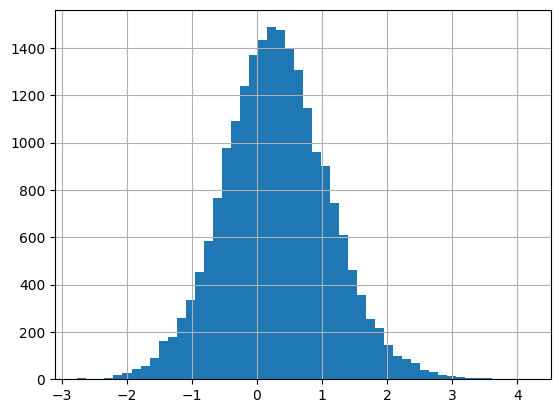

In [35]:
# Let's visualize how this looks like for all interactions  (across all cell types)
lr_res = lr_res.sort_values("interaction_stat", ascending=False)
lr_res['interaction_stat'].hist(bins=50)

/work/miniconda3/envs/liana/lib/python3.8/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/work/miniconda3/envs/liana/lib/python3.8/site-packages/liana/plotting/_dotplot.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/work/miniconda3/envs/liana/lib/python3.8/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.



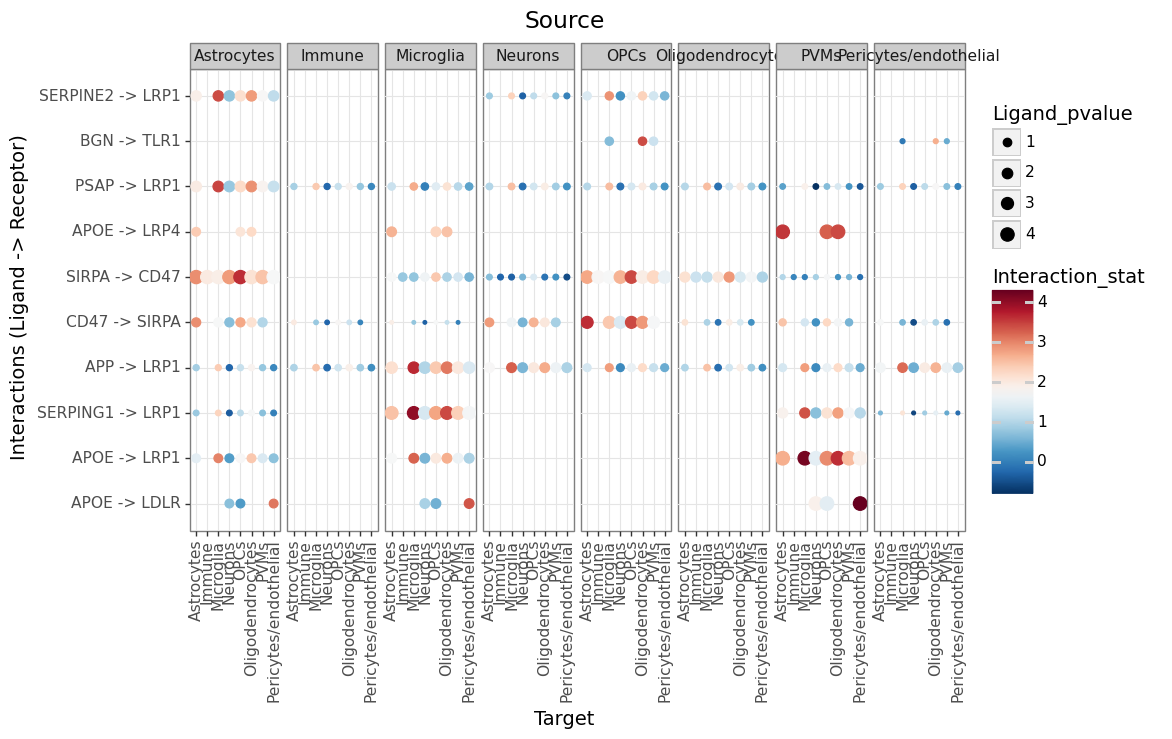

<ggplot: (8792398298634)>

In [32]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='ligand_pvalue',
                     inverse_size=True,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     top_n=10,
                     size_range=(1, 5)
                     )

# customize plot
plot = plot + p9.theme_bw(base_size=14) + p9.scale_color_cmap('RdBu_r') + p9.theme(axis_text_x=p9.element_text(angle=90))
plot + p9.theme(figure_size=(10, 6))

### PD

In [35]:
adatacp = adata[adata.obs[condition_key]=='PD', ].copy()
sc.pp.normalize_total(adatacp, target_sum=1e4)
sc.pp.log1p(adatacp)
adatacp

AnnData object with n_obs × n_vars = 42801 × 25550
    obs: 'anno', 'condition', 'sample', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

In [36]:
lr_res = li.multi.df_to_lr(adatacp,
                           dea_df=dea_df,
                           resource_name='consensus',
                           expr_prop=0.1, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['stat', 'pvalue', 'padj'],
                           use_raw=False,
                           complex_col='stat', # NOTE: we use the Wald Stat to deal with complexes
                           verbose=True,
                           return_all_lrs=False,
                           )

Using resource `consensus`.
Using `.X`!
1540 features of mat are empty, they will be removed.
/work/miniconda3/envs/liana/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
0.31 of entities in the resource are missing from the data.


In [56]:
lr_res = lr_res.sort_values("interaction_stat", ascending=False, key=abs)
lr_res

,ligand,receptor,ligand_complex,receptor_complex,source,ligand_stat,ligand_pvalue,ligand_padj,ligand_expr,ligand_props,...,receptor_pvalue,receptor_padj,receptor_expr,receptor_props,interaction_stat,interaction_pvalue,interaction_padj,interaction_expr,interaction_props,interaction
16616,APOE,LRP1,APOE,LRP1,PVMs,3.987402,0.000067,0.119547,0.470792,0.337255,...,0.000032,0.120545,0.855574,0.600075,4.073436,0.000049,0.120046,0.663183,0.468665,APOE^LRP1
5402,SERPING1,LRP1,SERPING1,LRP1,Microglia,3.624340,0.000290,0.252641,0.122728,0.105302,...,0.000032,0.120545,0.855574,0.600075,3.891905,0.000161,0.186593,0.489151,0.352689,SERPING1^LRP1
5390,APP,LRP1,APP,LRP1,Microglia,3.140842,0.001685,0.376722,0.262228,0.194175,...,0.000032,0.120545,0.855574,0.600075,3.650156,0.000858,0.248634,0.558901,0.397125,APP^LRP1
16764,APOE,LRP4,APOE,LRP4,PVMs,3.987402,0.000067,0.119547,0.470792,0.337255,...,0.001548,0.358239,0.456507,0.389843,3.576433,0.000808,0.238893,0.463650,0.363549,APOE^LRP4
12990,CD47,SIRPA,CD47,SIRPA,OPCs,3.118125,0.001820,0.471958,0.538532,0.494159,...,0.000071,0.123104,0.230198,0.247664,3.545336,0.000946,0.297531,0.384365,0.370911,CD47^SIRPA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9624,SLITRK5,PTPRD,SLITRK5,PTPRD,Neurons,0.898642,0.368843,0.999820,0.498712,0.679100,...,0.369223,0.716801,3.266861,0.981435,0.000356,0.369033,0.858310,1.882786,0.830267,SLITRK5^PTPRD
17346,SPTAN1,PTPRA,SPTAN1,PTPRA,PVMs,0.013696,0.989072,0.999296,0.173218,0.149020,...,0.988597,0.996813,0.627435,0.425693,-0.000298,0.988834,0.998055,0.400326,0.287356,SPTAN1^PTPRA
8736,GDF11,BMPR2,GDF11,BMPR2,Neurons,0.452977,0.650565,0.999820,0.043028,0.135691,...,0.650896,0.999820,0.959924,0.817363,0.000230,0.650731,0.999820,0.501476,0.476527,GDF11^BMPR2
10602,COL11A1,ITGA10,COL11A1,ITGA10_ITGB1,Neurons,1.120493,0.262504,0.999820,0.284009,0.394212,...,0.262648,0.754854,0.698731,0.479452,0.000170,0.262576,0.877337,0.491370,0.436832,COL11A1^ITGA10_ITGB1


<Axes: >

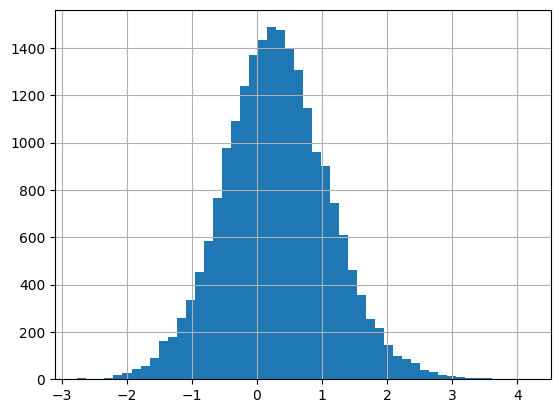

In [35]:
# Let's visualize how this looks like for all interactions  (across all cell types)
lr_res = lr_res.sort_values("interaction_stat", ascending=False)
lr_res['interaction_stat'].hist(bins=50)

/work/miniconda3/envs/liana/lib/python3.8/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/work/miniconda3/envs/liana/lib/python3.8/site-packages/liana/plotting/_dotplot.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/work/miniconda3/envs/liana/lib/python3.8/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.



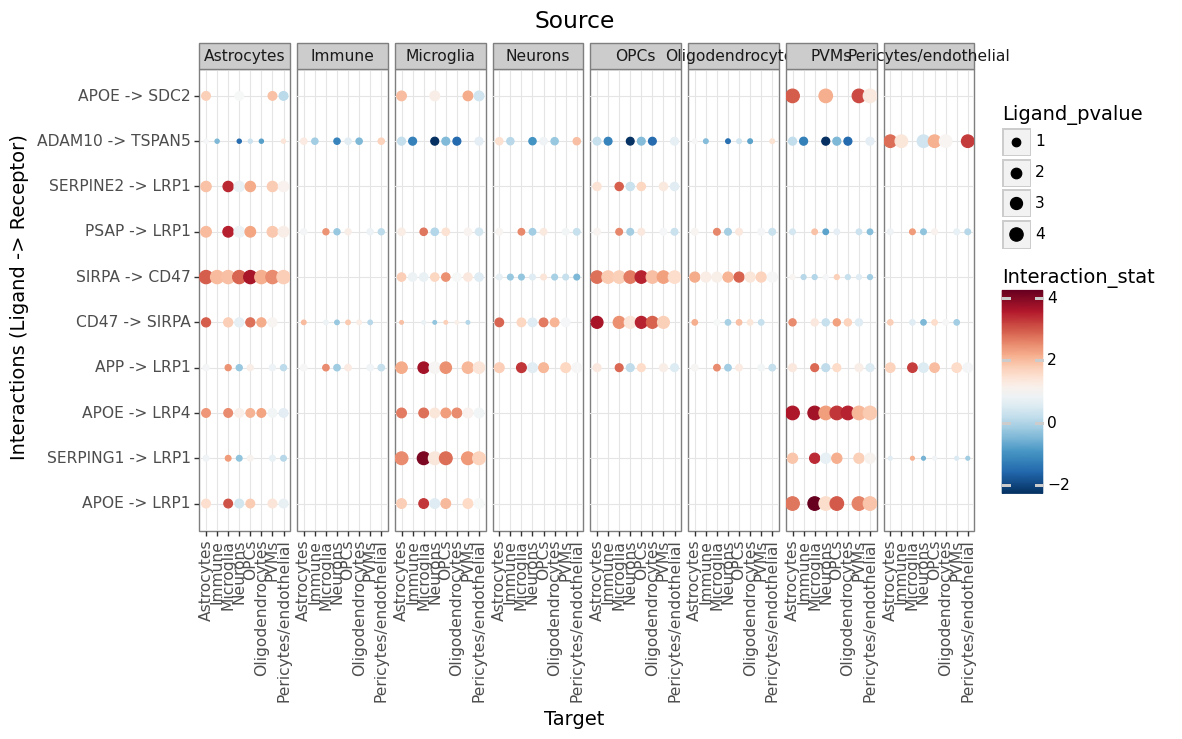

<ggplot: (8792889754682)>

In [37]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='ligand_pvalue',
                     inverse_size=True,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     top_n=10,
                     size_range=(1, 5)
                     )

# customize plot
plot = plot + p9.theme_bw(base_size=14) + p9.scale_color_cmap('RdBu_r') + p9.theme(axis_text_x=p9.element_text(angle=90))
plot + p9.theme(figure_size=(10, 6))